# Detecting Retina Damage From Optical Coherence Tomography (OCT) Images, using Transfer Learning on VGG16 CNN Model
## Context
Retinal Optical Coherence Tomography (OCT) is an imaging technique used to capture high-resolution cross sections of the retinas of living patients. Approximately 30 million OCT scans are performed each year, and the analysis and interpretation of these images takes up a significant amount of time (Swanson and Fujimoto, 2017).

![Figure 1.](https://i.imgur.com/fSTeZMd.png)

Figure 1. Representative Optical Coherence Tomography Images and the Workflow Diagram \[Kermany et. al. 2018\]

(A) (Far left) Choroidal Neo-Vascularization (CNV) with neovascular membrane (white arrowheads) and associated subretinal fluid (arrows). (Middle left) Diabetic Macular Edema (DME) with retinal-thickening-associated intraretinal fluid (arrows). (Middle right) Multiple drusen (arrowheads) present in early AMD. (Far right) Normal retina with preserved foveal contour and absence of any retinal fluid/edema.

## Content
* The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (NORMAL,CNV,DME,DRUSEN). There are 84,495 X-Ray images (JPEG) and 4 categories (NORMAL,CNV,DME,DRUSEN).
* Images are labeled as (disease)-(randomized patient ID)-(image number by this patient) and split into 4 directories: CNV, DME, DRUSEN, and NORMAL.

* Optical coherence tomography (OCT) images (Spectralis OCT, Heidelberg Engineering, Germany) were selected from retrospective cohorts of adult patients from the Shiley Eye Institute of the University of California San Diego, the California Retinal Research Foundation, Medical Center Ophthalmology Associates, the Shanghai First People’s Hospital, and Beijing Tongren Eye Center between July 1, 2013 and March 1, 2017.

## Acknowledgements
* Data: https://data.mendeley.com/datasets/rscbjbr9sj/2
* Citation: http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

## Installing and Importing Libraries

In [1]:
!pip install keract

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import os
from glob import glob
import pandas as pd
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sn
from skimage.transform import resize
from skimage.color import gray2rgb
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import SVG
import keract
from tensorflow import keras
from tensorflow.keras import applications, optimizers
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

## Importing Dataset and Data Pre-Processing

In [3]:
data_dir = "../input/kermany2018/OCT2017 /"
train_data_dir= '../input/kermany2018/OCT2017 /train/'
val_data_dir= '../input/kermany2018/OCT2017 /val/'
test_data_dir= '../input/kermany2018/OCT2017 /test/'
img_width, img_height = 150, 150 
channels = 3
batch_size = 32
# image_arr_size= img_width * img_height * channels

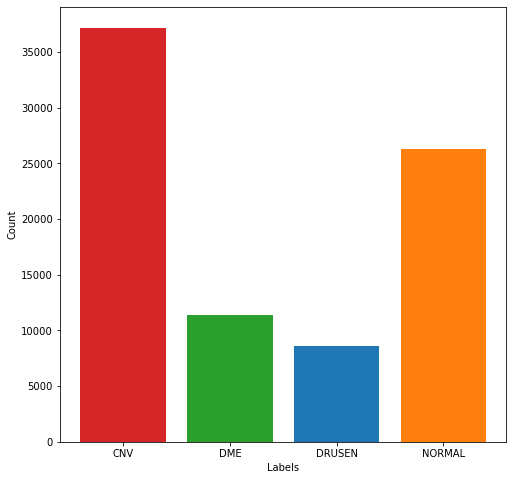

In [4]:
cnv_images = len(glob(train_data_dir + 'CNV/*.jpeg'))
dme_images = len(glob(train_data_dir + 'DME/*.jpeg'))
drusen_images = len(glob(train_data_dir + 'DRUSEN/*.jpeg'))
normal_images = len(glob(train_data_dir + 'NORMAL/*.jpeg'))
data= {'CNV': cnv_images, 'DME': dme_images, 'DRUSEN': drusen_images, 'NORMAL': normal_images}
labels = list(data.keys()) 
count = list(data.values()) 

plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.bar(labels, count, color=['tab:red', 'tab:green', 'tab:blue', 'tab:orange'])
plt.axis('on')
plt.xlabel("Labels") 
plt.ylabel("Count") 
plt.savefig('labels_vs_counts.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show() 

### Image Histogram (Tonal Distribution)
* Histogram of a normal retina image in the train dataset:

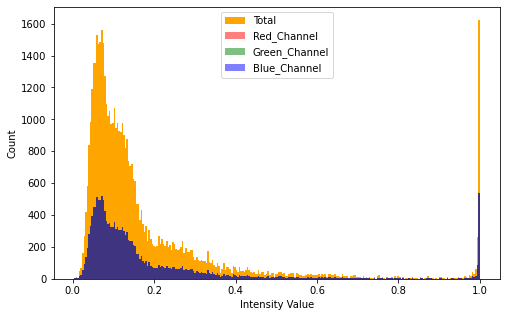

In [5]:
image = mpimg.imread(data_dir + 'train/NORMAL/NORMAL-1001666-1.jpeg')
color_img= gray2rgb(resize(image, (128, 128)))
plt.rcParams['figure.figsize'] = (8.0, 5.0)
_ = plt.hist(color_img.ravel(), bins = 256, color = 'orange', )
_ = plt.hist(color_img[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
_ = plt.hist(color_img[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
_ = plt.hist(color_img[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
_ = plt.xlabel('Intensity Value')
_ = plt.ylabel('Count')
_ = plt.legend(['Total', 'Red_Channel', 'Green_Channel', 'Blue_Channel'])
plt.savefig('histogram.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

### Sample Images from the Dataset

Normal


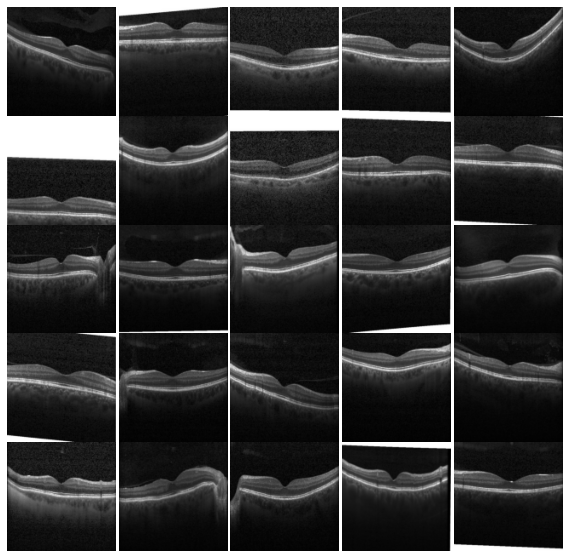

In [6]:
print("Normal")
multipleImages = glob(data_dir + 'train/NORMAL/**')
i = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for im in multipleImages[:25]:
    image = mpimg.imread(im)
    image_resized = resize(image, (128, 128)) 
    plt.subplot(5, 5, i+1) #.set_title(l)
    plt.imshow(gray2rgb(image_resized)); plt.axis('off')
    i += 1
plt.savefig('normal_eye.png', transparent= False, bbox_inches= 'tight', dpi= 400)

Choroidal Neo-Vascularization (CNV)


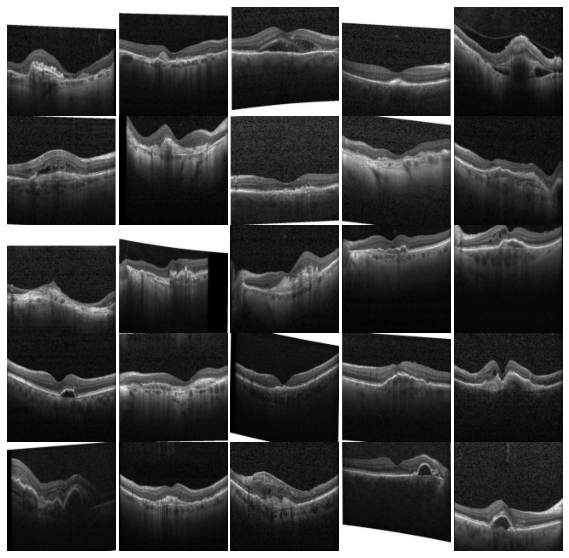

In [7]:
print("Choroidal Neo-Vascularization (CNV)")
multipleImages = glob(data_dir + 'train/CNV/**')
i = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for im in multipleImages[:25]:
    image = mpimg.imread(im)
    image_resized = resize(image, (128, 128)) 
    plt.subplot(5, 5, i+1) #.set_title(l)
    plt.imshow(gray2rgb(image_resized)); plt.axis('off')
    i += 1
plt.savefig('cnv_eye.png', transparent= False, bbox_inches= 'tight', dpi= 400)

Diabetic Macular Edema (DME)


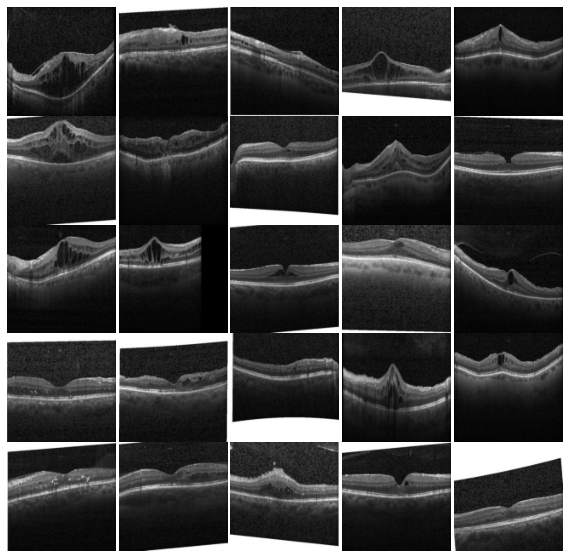

In [8]:
print("Diabetic Macular Edema (DME)") 
multipleImages = glob(data_dir + 'train/DME/**')
i = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for im in multipleImages[:25]:
    image = mpimg.imread(im)
    image_resized = resize(image, (128, 128)) 
    plt.subplot(5, 5, i+1) #.set_title(l)
    plt.imshow(gray2rgb(image_resized)); plt.axis('off')
    i += 1
plt.savefig('dme_eye.png', transparent= False, bbox_inches= 'tight', dpi= 400)

Drusen


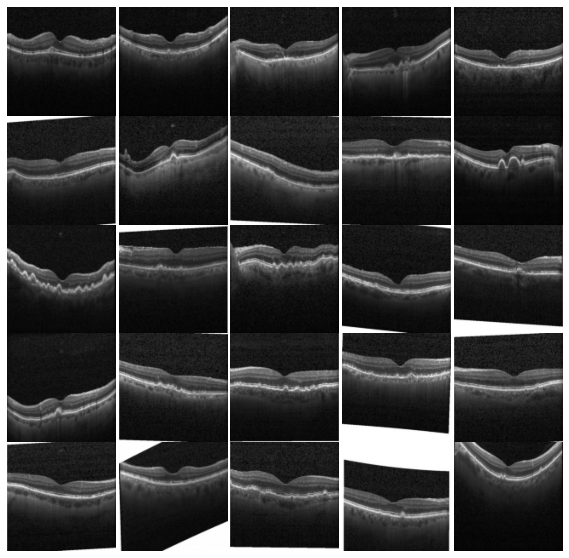

In [9]:
print("Drusen")
multipleImages = glob(data_dir + 'train/DRUSEN/**')
i = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for im in multipleImages[:25]:
    image = mpimg.imread(im)
    image_resized = resize(image, (128, 128)) 
    plt.subplot(5, 5, i+1) #.set_title(l)
    plt.imshow(gray2rgb(image_resized)); plt.axis('off')
    i += 1
plt.savefig('drusen_eye.png', transparent= False, bbox_inches= 'tight', dpi= 400)

### Keras Data Generators

In [10]:
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    zoom_range= (0.73, 0.9),
    horizontal_flip= True,
    rotation_range= 10,
    width_shift_range= 0.10,
    fill_mode= 'constant',
    height_shift_range= 0.10,   
    brightness_range= (0.55, 0.9),
)

valid_test_datagen = ImageDataGenerator(
    rescale= 1./255, 
)

In [11]:
train_generator = train_datagen.flow_from_directory(  
    train_data_dir,  
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    shuffle= True, 
    seed= 1337
) 

valid_generator = valid_test_datagen.flow_from_directory(
    val_data_dir,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    shuffle= True, 
    seed= 1337
)

test_generator = valid_test_datagen.flow_from_directory(  
    test_data_dir,  
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,        
    class_mode= 'categorical',
    shuffle= False, 
)

Found 83484 images belonging to 4 classes.
Found 32 images belonging to 4 classes.
Found 968 images belonging to 4 classes.


In [12]:
num_classes = len(train_generator.class_indices)  
train_labels = train_generator.classes 
train_labels = to_categorical(train_labels, num_classes=num_classes)
valid_labels = valid_generator.classes 
valid_labels = to_categorical(valid_labels, num_classes=num_classes)
nb_train_samples = len(train_generator.filenames)  
nb_valid_samples = len(valid_generator.filenames)
nb_test_samples = len(test_generator.filenames)

### Image Data Augmentation

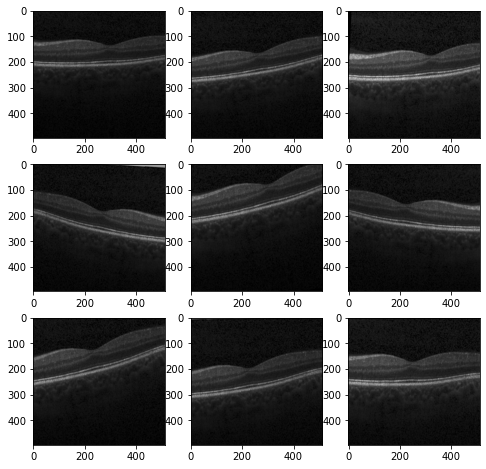

In [13]:
img = load_img('../input/kermany2018/OCT2017 /train/NORMAL/NORMAL-1001772-4.jpeg')
data = img_to_array(img)
samples = expand_dims(data, 0)
it = train_datagen.flow(samples, batch_size=1)
plt.rcParams['figure.figsize'] = (8.0, 8.0)

for i in range(9):
	plt.subplot(330 + 1 + i)
	batch = it.next()
	image = batch[0]
	plt.imshow(image)

plt.savefig('augmented_image.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

# Model
* VGG16 CNN architecture is used for calssification.
* Pretrained on the 'ImageNet' dataset.

In [14]:
vgg16 = VGG16(include_top= False, input_shape= (img_width, img_height, channels), weights= 'imagenet')
vgg16.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [15]:
model = Sequential()

for layer in vgg16.layers:
    model.add(layer)

for layer in model.layers:
    layer.trainable= False

model.add(Flatten(input_shape= (4, 4, 512)))
model.add(Dropout(0.2))
model.add(Dense(4,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 37, 37, 256)       2

### VGG16 Architecture

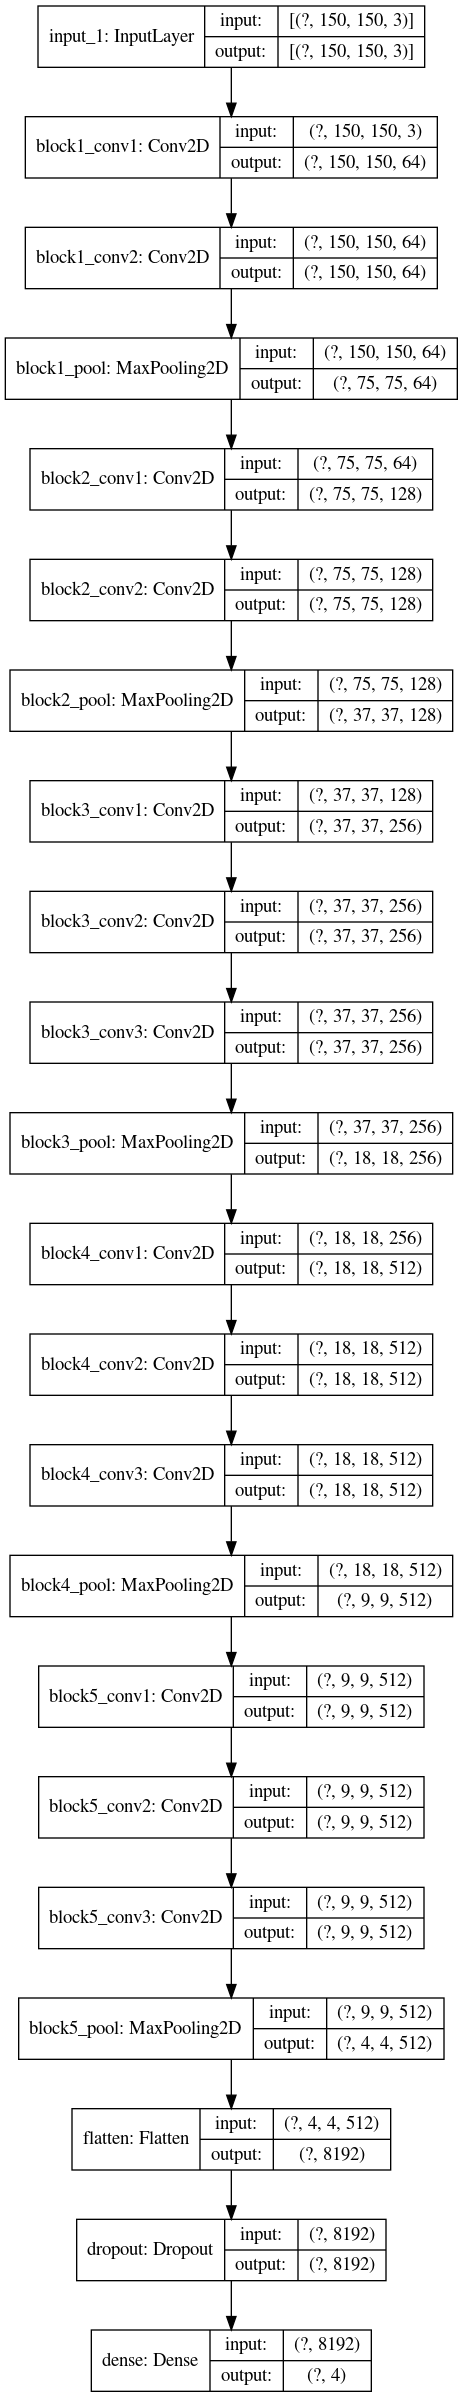

In [16]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)

## Baseline Model Training

In [17]:
model.compile(optimizer= keras.optimizers.Adam(lr= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [18]:
checkpoint = ModelCheckpoint(
    'baseline_model.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=False,
    period=1
)

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='auto'
)

csvlogger = CSVLogger(
    filename= "baseline_training_csv.log",
    separator = ",",
    append = False
)

reduceLR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint, earlystop, csvlogger,reduceLR]


In [19]:
history = model.fit(
    train_generator, 
    epochs = 30,
    steps_per_epoch = nb_train_samples//batch_size,
    validation_data = valid_generator, 
    validation_steps = nb_valid_samples//batch_size,
    verbose = 2,
    callbacks = callbacks,
    shuffle = True
)

Epoch 1/30

Epoch 00001: val_loss improved from inf to 0.48476, saving model to baseline_model.h5
2608/2608 - 879s - loss: 0.6664 - accuracy: 0.7586 - val_loss: 0.4848 - val_accuracy: 0.7500
Epoch 2/30

Epoch 00002: val_loss improved from 0.48476 to 0.42680, saving model to baseline_model.h5
2608/2608 - 722s - loss: 0.5100 - accuracy: 0.8151 - val_loss: 0.4268 - val_accuracy: 0.7812
Epoch 3/30

Epoch 00003: val_loss improved from 0.42680 to 0.34936, saving model to baseline_model.h5
2608/2608 - 720s - loss: 0.4694 - accuracy: 0.8307 - val_loss: 0.3494 - val_accuracy: 0.9062
Epoch 4/30

Epoch 00004: val_loss did not improve from 0.34936
2608/2608 - 723s - loss: 0.4503 - accuracy: 0.8381 - val_loss: 0.3952 - val_accuracy: 0.8438
Epoch 5/30

Epoch 00005: val_loss did not improve from 0.34936
2608/2608 - 728s - loss: 0.4383 - accuracy: 0.8414 - val_loss: 0.3654 - val_accuracy: 0.8438
Epoch 6/30

Epoch 00006: val_loss improved from 0.34936 to 0.34346, saving model to baseline_model.h5
2608/

In [20]:
(eval_loss, eval_accuracy) = model.evaluate(test_generator, batch_size= batch_size, verbose= 1)
print('Test Loss: ', eval_loss)
print('Test Accuracy: ', eval_accuracy)

31/31 [==============================] - 4s 142ms/step - loss: 0.3551 - accuracy: 0.8719
Test Loss:  0.3551199436187744
Test Accuracy:  0.8719007968902588


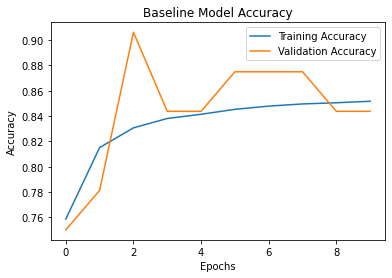

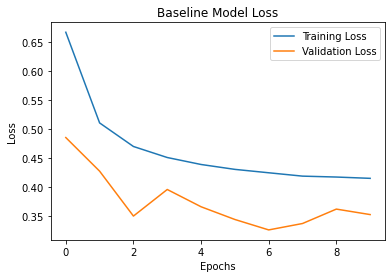

In [23]:
plt.subplot()
plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.title('Baseline Model Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.savefig('baseline_acc_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

plt.subplot()
plt.title('Baseline Model Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.savefig('baseline_loss_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

## Finetuning with Reduced Learning Rate
* Unfroze model weights.
* Reduced learning rate.

In [55]:
model.trainable= True
model.compile(optimizer= keras.optimizers.Adam(1e-5), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [54]:
checkpoint = ModelCheckpoint(
    'finetuned_model.h5',
    monitor='loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=False,
    period=1
)

earlystop = EarlyStopping(
    monitor='loss',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='auto'
)

csvlogger = CSVLogger(
    filename= "finetuned_training_csv.log",
    separator = ",",
    append = False
)

reduceLR = ReduceLROnPlateau(
    monitor='loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint, earlystop, csvlogger,reduceLR]

In [56]:
history_1 = model.fit(
    train_generator, 
    epochs = 10,
    steps_per_epoch = nb_train_samples//batch_size,
    validation_data = valid_generator, 
    validation_steps = nb_valid_samples//batch_size,
    verbose = 2,
    callbacks = callbacks,
    shuffle = True
)

Epoch 1/10

Epoch 00001: loss improved from inf to 0.25207, saving model to finetuned_model.h5
2608/2608 - 886s - loss: 0.2521 - accuracy: 0.9145 - val_loss: 0.0297 - val_accuracy: 1.0000
Epoch 2/10

Epoch 00002: loss improved from 0.25207 to 0.17267, saving model to finetuned_model.h5
2608/2608 - 908s - loss: 0.1727 - accuracy: 0.9416 - val_loss: 0.0403 - val_accuracy: 1.0000
Epoch 3/10

Epoch 00003: loss improved from 0.17267 to 0.14978, saving model to finetuned_model.h5
2608/2608 - 917s - loss: 0.1498 - accuracy: 0.9494 - val_loss: 0.0480 - val_accuracy: 1.0000
Epoch 4/10

Epoch 00004: loss improved from 0.14978 to 0.13221, saving model to finetuned_model.h5
2608/2608 - 905s - loss: 0.1322 - accuracy: 0.9556 - val_loss: 0.0154 - val_accuracy: 1.0000
Epoch 5/10

Epoch 00005: loss improved from 0.13221 to 0.12194, saving model to finetuned_model.h5
2608/2608 - 896s - loss: 0.1219 - accuracy: 0.9590 - val_loss: 0.0170 - val_accuracy: 1.0000
Epoch 6/10

Epoch 00006: loss improved from 

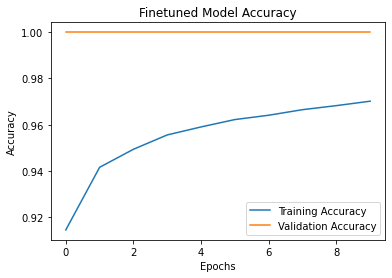

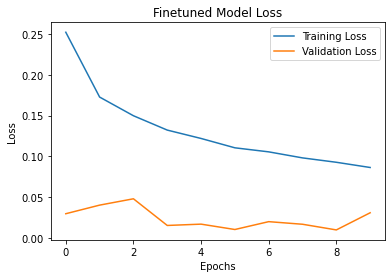

In [57]:
plt.subplot()
plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.title('Finetuned Model Accuracy')
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.savefig('finetuned_acc_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

plt.subplot()
plt.title('Finetuned Model Loss')
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.savefig('finetuned_loss_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

## Evaluations on Test Dataset

In [58]:
(eval_loss, eval_accuracy) = model.evaluate(test_generator, batch_size= batch_size, verbose= 1)
print('Test Loss: ', eval_loss)
print('Test Accuracy: ', eval_accuracy)

31/31 [==============================] - 3s 95ms/step - loss: 0.0489 - accuracy: 0.9897
Test Loss:  0.048944141715765
Test Accuracy:  0.9896694421768188


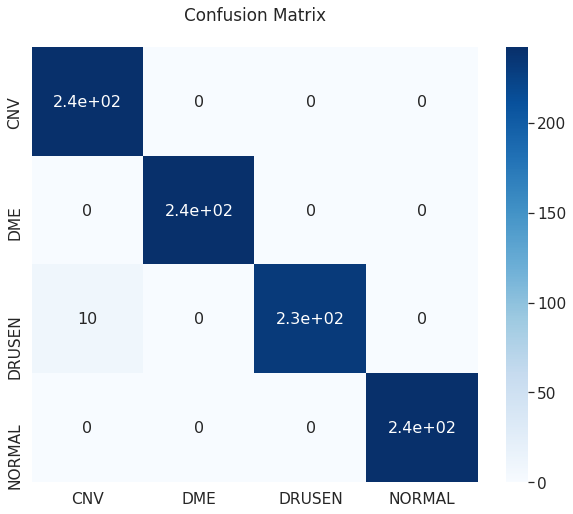

Classification Report

              precision    recall  f1-score   support

         CNV       0.96      1.00      0.98       242
         DME       1.00      1.00      1.00       242
      DRUSEN       1.00      0.96      0.98       242
      NORMAL       1.00      1.00      1.00       242

    accuracy                           0.99       968
   macro avg       0.99      0.99      0.99       968
weighted avg       0.99      0.99      0.99       968



In [60]:
Y_pred = model.predict(test_generator, nb_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_generator.classes, y_pred)
df_cm = pd.DataFrame(cm, list(test_generator.class_indices.keys()), list(test_generator.class_indices.keys()))
fig, ax = plt.subplots(figsize=(10,8))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap=plt.cm.Blues)
plt.title('Confusion Matrix\n')
plt.savefig('confusion_matrix.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

print('Classification Report\n')
target_names = list(test_generator.class_indices.keys())
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

## Visualization

In [61]:
image = load_img('../input/kermany2018/OCT2017 /test/NORMAL/NORMAL-1017237-1.jpeg', target_size= (img_width, img_height))
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)
y_hat = model.predict(image)

In [62]:
activations= keract.get_activations(model, image, layer_names= None, nodes_to_evaluate= None, output_format= 'simple', auto_compile= True)
keract.display_activations(activations, save= True, directory= '/kaggle/working/activations')

input_1_5 (1, 150, 150, 3) 
block1_conv1 (1, 150, 150, 64) 
block1_conv2 (1, 150, 150, 64) 
block1_pool (1, 75, 75, 64) 
block2_conv1 (1, 75, 75, 128) 
block2_conv2 (1, 75, 75, 128) 
block2_pool (1, 37, 37, 128) 
block3_conv1 (1, 37, 37, 256) 
block3_conv2 (1, 37, 37, 256) 
block3_conv3 (1, 37, 37, 256) 
block3_pool (1, 18, 18, 256) 
block4_conv1 (1, 18, 18, 512) 
block4_conv2 (1, 18, 18, 512) 
block4_conv3 (1, 18, 18, 512) 
block4_pool (1, 9, 9, 512) 
block5_conv1 (1, 9, 9, 512) 
block5_conv2 (1, 9, 9, 512) 
block5_conv3 (1, 9, 9, 512) 
block5_pool (1, 4, 4, 512) 
flatten (1, 8192) 
dropout (1, 8192) 
dense (1, 4) 


In [64]:
keract.display_heatmaps(activations, image, save= True, directory= '/kaggle/working/heatmaps')

input_1_5 (1, 150, 150, 3) 
block1_conv1 (1, 150, 150, 64) 
block1_conv2 (1, 150, 150, 64) 
block1_pool (1, 75, 75, 64) 
block2_conv1 (1, 75, 75, 128) 
block2_conv2 (1, 75, 75, 128) 
block2_pool (1, 37, 37, 128) 
block3_conv1 (1, 37, 37, 256) 
block3_conv2 (1, 37, 37, 256) 
block3_conv3 (1, 37, 37, 256) 
block3_pool (1, 18, 18, 256) 
block4_conv1 (1, 18, 18, 512) 
block4_conv2 (1, 18, 18, 512) 
block4_conv3 (1, 18, 18, 512) 
block4_pool (1, 9, 9, 512) 
block5_conv1 (1, 9, 9, 512) 
block5_conv2 (1, 9, 9, 512) 
block5_conv3 (1, 9, 9, 512) 
block5_pool (1, 4, 4, 512) 
flatten (1, 8192) -> Skipped. 2D Activations.
dropout (1, 8192) -> Skipped. 2D Activations.
dense (1, 4) -> Skipped. 2D Activations.
